# Model Selection

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import warnings

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [5]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [6]:
DATAM = {'papalexi_all': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert18',
                    'nt_condition': "THP-1_NT_1.0"}}
dataset = 'papalexi_all'
DATA = DATAM[dataset]
mulpert_models_imp = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")

In [7]:
spt = 'test'
focus_metric_1 = f"{spt}_mean_score_genes_last"
focus_metric_2 = f"{spt}_mean_score_proteins_last"

mulpert_models = mulpert_models_imp[(mulpert_models_imp['status'] == 1)]
mulpert_models["overall_best"] = mulpert_models[focus_metric_1]**2 * np.sign(mulpert_models[focus_metric_1]) + mulpert_models[focus_metric_2]**2 * np.sign(mulpert_models[focus_metric_2])
mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)

scores = [f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_proteins_last", "overall_best"]
df = mulpert_models.drop_duplicates(subset="config.model.model_type", keep='first')
df[["config.db_collection", "config.dataset.dataset_args.dataset_path", 'config.dataset.dataset_args.split_key', "config.model.model_type", "status"] + scores]

/tmp/ipykernel_238452/1057773291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mulpert_models["overall_best"] = mulpert_models[focus_metric_1]**2 * np.sign(mulpert_models[focus_metric_1]) + mulpert_models[focus_metric_2]**2 * np.sign(mulpert_models[focus_metric_2])


,config.db_collection,config.dataset.dataset_args.dataset_path,config.dataset.dataset_args.split_key,config.model.model_type,status,test_mean_score_genes_last,test_mean_score_proteins_last,overall_best
_id,,,,,,,,
16695,mpert18,datasets/Papalexi21_prep.h5ad,split,TotalComPert,1,0.962966,0.974521,1.876994
21531,mpert18,datasets/Papalexi21_prep.h5ad,split,TotalPoEComPert,1,0.968005,0.563847,1.254957
18611,mpert18,datasets/Papalexi21_prep.h5ad,split,PoEComPert,1,0.946323,-0.212045,0.850565
1203,mpert18,datasets/Papalexi21_prep.h5ad,split,ComPert,1,0.959973,-0.284902,0.840379


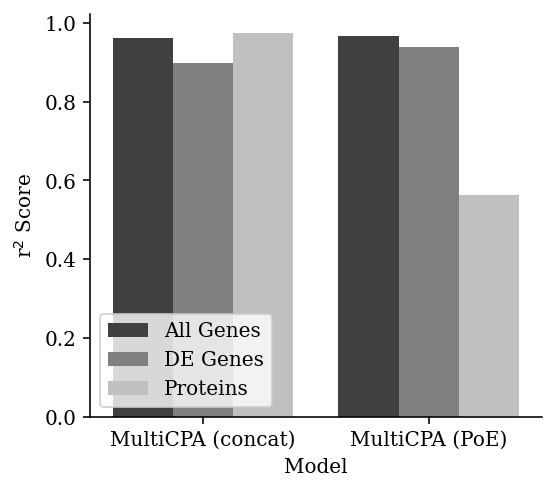

In [8]:

a1 = df[["config.model.model_type", f"{'test'}_mean_score_genes_last"]]
a2 = df[["config.model.model_type", f"{'test'}_mean_score_genes_de_last"]]
a3 = df[["config.model.model_type", f"{'test'}_mean_score_proteins_last"]]

a1.columns = ["Model", "Score"]
a2.columns = ["Model", "Score"]
a3.columns = ["Model", "Score"]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    a1["Feature Set"] = "All Genes"
    a2["Feature Set"] = "DE Genes"
    a3["Feature Set"] = "Proteins"

a = pd.concat([a1, a2, a3], axis=0)
a = a[a['Model'].isin(['TotalComPert', 'TotalPoEComPert'])]
a['Model'] = a['Model'].replace({'TotalComPert': 'MultiCPA (concat)', 'TotalPoEComPert': 'MultiCPA (PoE)'})

with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(4, 3.5))
    g = sns.barplot(data=a, x="Model", y="Score", hue="Feature Set", palette='gray')
    g.legend(loc='lower left')
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig('figures/model_selection.pdf')

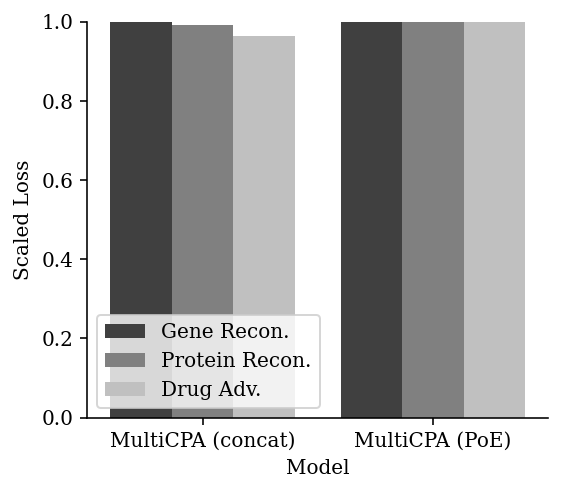

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df["result.loss_reconstruction_genes_last"] = list(pd.DataFrame(list(df["result.loss_reconstruction_genes"])).iloc[:,-1])
    df["result.loss_reconstruction_proteins_last"] = list(pd.DataFrame(list(df["result.loss_reconstruction_proteins"])).iloc[:,-1])
    df["result.loss_adv_drugs_last"] = list(pd.DataFrame(list(df["result.loss_adv_drugs"])).iloc[:,-1])
    # keep only these two
    df = df[df["config.model.model_type"].isin(['TotalComPert', 'TotalPoEComPert'])]

a1 = df[["config.model.model_type", "result.loss_reconstruction_genes_last"]]
a2 = df[["config.model.model_type", "result.loss_reconstruction_proteins_last"]]
a3 = df[["config.model.model_type", "result.loss_adv_drugs_last"]]


a1.columns = ["Model", "Score"]
a2.columns = ["Model", "Score"]
a3.columns = ["Model", "Score"]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    a1["Loss"] = "Gene Recon."
    a2["Loss"] = "Protein Recon."
    a3["Loss"] = "Drug Adv."
    a1s = a1["Score"]
    a2s = a2["Score"]
    a3s = a3["Score"]
    a1["Score"] = a1s/ a1s.max()
    a2["Score"] = a2s/ a2s.max()
    a3["Score"] = a3s/ a3s.max()
    
    #a1["Score"] = (a1s-a1s.mean())/a1s.std()
    #from sklearn import preprocessing
    #a2["Score"] = preprocessing.minmax_scale(a2["Score"])
    #a1["Score"] = (a1s - a1s.mean()) / (a1s.max() - a1s.min())

a = pd.concat([a1, a2, a3], axis=0)
a['Model'] = a['Model'].replace({'TotalComPert': 'MultiCPA (concat)', 'TotalPoEComPert': 'MultiCPA (PoE)'})

with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(4, 3.5))
    g = sns.barplot(data=a, x="Model", y="Score", hue="Loss", palette='gray')
    g.legend(loc='lower left')
    plt.ylabel("Scaled Loss")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig('figures/model_selection_loss.pdf')

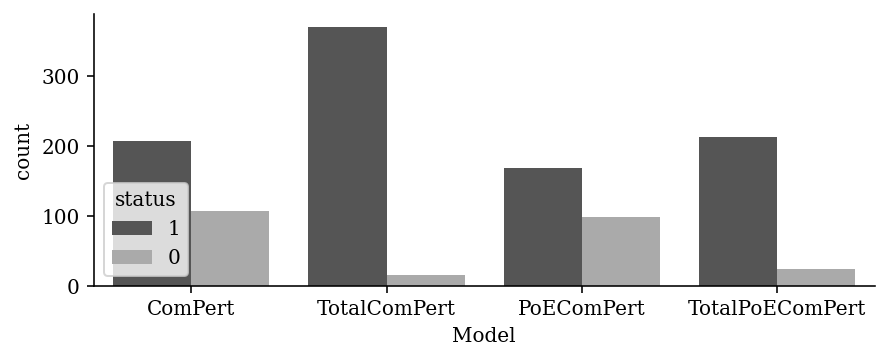

In [10]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(7, 2.5))
    g = sns.countplot(data=mulpert_models_imp, x="config.model.model_type", hue="status", hue_order=[1,0], palette='gray')
    sns.move_legend(g, "lower left")
    plt.xlabel('Model')
    plt.show()